In [1]:
import pandas as pd
from openpyxl import load_workbook
import matplotlib.pyplot as plt
import matplotlib as mpl
import os.path
import os
import numpy as np
import seaborn as sb
import copy
from matplotlib.colors import ListedColormap

from scipy.spatial import distance_matrix # for the euclidean distance matrix
from scipy.spatial.distance import cdist # for the euclidean distance matrix

import googlemaps as gmaps # for the google maps distance matrix
from itertools import tee # for the google maps distance matrix

In [2]:
path = '/Users/sakshimohan/Dropbox (Personal)/York/Research Projects/Drug Redistribution Problem/'
os.chdir(path)
os.getcwd()

'/Users/sakshimohan/Dropbox (Personal)/York/Research Projects/Drug Redistribution Problem'

In [3]:
# Load workbook
wb = load_workbook('LMIS Data/2018 LMIS Data.xlsx', data_only=True)
sheet2018 = wb['2018 LMIS Data']

In [4]:
# Create stockout dataframe
lmis = pd.DataFrame(sheet2018.values)
lmis.columns = lmis.iloc[0]
lmis = lmis.reindex(lmis.index.drop(0))

In [6]:
# Rename columns
NameChangeList = [('RYear','year'),\
                  ('RMonth','month'),\
                  ('Name (Geographic Zones)','district'),\
                  ('Name (Facility Operators)','fac_owner'),\
                  ('Name','fac_name'),\
                  ('fac_name (Programs)','program'),\
                  ('fac_name (Facility Types)','fac_type'),\
                  ('Fullproductname','drug'),\
                  ('Closing Bal','closing_bal'),\
                  ('Dispensed','dispensed'),\
                  ('AMC','amc'),\
                  ('Received','received'),\
                  ('Stockout days','stkout_days'),\
                ]

def change_colnames(df, NameChangeList):
    ColNames = df.columns
    ColNames2 = ColNames
    for (a,b) in NameChangeList:
        print(a,'-->',b)
        ColNames2 = [col.replace(a,b) for col in ColNames2]
    df.columns = ColNames2   
    return df

change_colnames(lmis, NameChangeList)

lmis_preserve = copy.deepcopy(lmis) # preserve a copy of the clean dataframe

RYear --> year
RMonth --> month
Name (Geographic Zones) --> district
Name (Facility Operators) --> fac_owner
Name --> fac_name
fac_name (Programs) --> program
fac_name (Facility Types) --> fac_type
Fullproductname --> drug
Closing Bal --> closing_bal
Dispensed --> dispensed
AMC --> amc
Received --> received
Stockout days --> stkout_days


In [7]:
lmis['drug'].nunique()

393

In [7]:
numerical_vars = ['amc', 'stkout_days','closing_bal','dispensed','received']
for var in numerical_vars:
    lmis[var] = pd.to_numeric(lmis[var])
    
# Index of series is column name.
dataTypeSeries = lmis.dtypes
dataTypeSeries 

year            object
month           object
district        object
fac_owner       object
fac_name        object
program         object
fac_type        object
drug            object
closing_bal    float64
dispensed      float64
stkout_days    float64
amc            float64
received       float64
dtype: object

In [10]:
lmis_test = lmis.groupby('drug').sum()
lmis_test.to_csv('drug_list_lmis.csv')
lmis_test.head()

,closing_bal,dispensed,stkout_days,amc,received
drug,,,,,
"(INACTIVE) Hydrogen peroxide, 20 vol.",37.0,0.0,0.0,0.00001,0.0
(INACTIVE)RH 60/60,193799.0,13978.0,307.0,15174.00020,856.0
(INACTIVE)RHZ 60/30/150,206530.0,18281.0,326.0,19731.00019,18164.0
"Abacavir (ABC) + Lamivudine(3TC), 60mg+30mg, 60''S (9P)",193022.0,43422.0,1551.0,44487.00218,49246.0
"Abacavir/Lamivudine (ABC/3TC), 60+30mg",96413.0,24686.0,1195.0,25765.10000,12872.0


In [8]:
# Temporarily reduce the size of the data so that tests run more quickly
    #lmis = lmis[lmis['drug'].isin([listGoesHere])]
#lmis_test = lmis.set_index('drug').groupby('drug', axis = 1).sum() 
lmis_test = lmis.groupby('drug').sum()
lmis_test = lmis_test.sort_values(['dispensed'],ascending=False).head(25)
lmis_test = lmis_test.reset_index(level = 0) 
lmis_test

# make a list of the top 25 dispensed drugs
topdruglist = lmis_test['drug']
topdrugs = set(topdruglist)
print(topdrugs)

# Create a subset of the original dataframe with 4 districts and only top 25 dispensed drugs
lmis = lmis[lmis['drug'].isin(topdrugs)]
lmis = lmis[lmis['district'].isin(['Blantyre'])] # can add other districts in the dataset
lmis = lmis.reset_index(level = 0) 
lmis

{'Cotrimoxazole 960mg Tabs', 'Ibuprofen 200mg Tabs', 'Aspirin 300mg, tablets', 'Amoxycillin 250mg Dispersible tablets', 'Amoxycillin 250mg, Tablets', 'Ferrous sulphate 200mg / folic acid 250 micrograms', 'Hydrochlorothiazide 25mg', 'Paracetamol 500mg', 'Isoniazid 300mg', 'Cotrimoxazole 120mg Tablets', 'Phenobarbitone 30mg', 'Lumefantrine 120mg/Artemether 20mg,6x1', 'Cotrimoxazole, 960 mg', 'Lumefantrine 120mg/Artemether 20mg,  6x3', 'Male Condoms', 'Magnesium trisilicate compound', 'Lumefantrine 120mg/Artemether 20mg, 6x4', 'Lumefantrine 120mg/Artemether 20mg, 6x2', 'Cotrimoxazole (dispersible tabs), 100+20mg', 'Cotrimoxazole 480mg tablets', 'Male condoms, Each', 'Cotrimoxazole, 400+ 80mg', 'Pyridoxine (Vitamin B6) 50mg', 'Metronidazole, 200mg', 'Metronidazole 200mg'}


,index,year,month,district,fac_owner,fac_name,program,fac_type,drug,closing_bal,dispensed,stkout_days,amc,received
0,1309,2018,January,Blantyre,CHAM,Chileka SDA Health Centre,Essential Meds,CHAM,Cotrimoxazole 120mg Tablets,50000.0,5000.0,0.0,3334.0,0.0
1,1312,2018,January,Blantyre,CHAM,Chileka SDA Health Centre,Essential Meds,CHAM,Metronidazole 200mg,21000.0,0.0,0.0,334.0,0.0
2,1316,2018,January,Blantyre,CHAM,Chileka SDA Health Centre,HIV,CHAM,Cotrimoxazole 960mg Tabs,114000.0,14000.0,0.0,17000.0,0.0
3,1329,2018,January,Blantyre,CHAM,Chileka SDA Health Centre,Malaria,CHAM,"Lumefantrine 120mg/Artemether 20mg, 6x2",4320.0,2842.0,0.0,1308.0,0.0
4,1330,2018,January,Blantyre,CHAM,Chileka SDA Health Centre,Malaria,CHAM,"Lumefantrine 120mg/Artemether 20mg, 6x3",4860.0,540.0,0.0,180.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6897,699081,2018,December,Blantyre,Government of Malawi,Zingwangwa Health Centre,Essential Meds,None,Ferrous sulphate 200mg / folic acid 250 microg...,0.0,15000.0,NaN,29069.0,1000.0
6898,699083,2018,December,Blantyre,Government of Malawi,Zingwangwa Health Centre,Essential Meds,None,Ibuprofen 200mg Tabs,0.0,10000.0,NaN,12977.0,10000.0
6899,699084,2018,December,Blantyre,Government of Malawi,Zingwangwa Health Centre,Essential Meds,None,Magnesium trisilicate compound,0.0,0.0,NaN,10667.0,0.0
6900,699086,2018,December,Blantyre,Government of Malawi,Zingwangwa Health Centre,Essential Meds,None,"Metronidazole, 200mg",0.0,31000.0,NaN,11482.0,20000.0


In [9]:
# Create a list of district names:
districtlist = lmis['district']
districts = set(districtlist)
print(districts)

{'Blantyre'}


In [10]:
lmis['cb_amc'] = lmis['closing_bal']# - lmis['amc']

table = pd.pivot_table(lmis[lmis['month']=='January'], values=['cb_amc'], index='drug', columns = 'fac_name',
                    aggfunc={'cb_amc': np.mean})
table

cb_amc  \
fac_name                                           Bangwe Health Centre   
drug                                                                      
Amoxycillin 250mg Dispersible tablets                            9100.0   
Amoxycillin 250mg, Tablets                                       9000.0   
Aspirin 300mg, tablets                                          19000.0   
Cotrimoxazole 120mg Tablets                                    571000.0   
Cotrimoxazole 480mg tablets                                    443000.0   
Cotrimoxazole 960mg Tabs                                       479000.0   
Ferrous sulphate 200mg / folic acid 250 micrograms              12000.0   
Hydrochlorothiazide 25mg                                        18000.0   
Ibuprofen 200mg Tabs                                                NaN   
Isoniazid 300mg                                                478263.0   
Lumefantrine 120mg/Artemether 20mg,  6x3                        10260.0   
Lumefantrine 120mg/Artemether 20mg, 6x2                          6992.0   
Lumefantrine 120mg/Artemether 20mg, 6x4                         17260.0   
Lumefantrine 120mg/Artemether 20mg,6x1                          12320.0   
Magnesium trisilicate compound                                   6000.0   
Male Condoms                                                    82080.0   
Metronidazole 200mg                                             44000.0   
Paracetamol 500mg                                               23000.0   
Phenobarbitone 30mg                                             34000.0   
Pyridoxine (Vitamin B6) 50mg                                   399190.0   

                                                                          \
fac_name                                           Blantyre DHO Pharmacy   
drug                                                                       
Amoxycillin 250mg Dispersible tablets                                NaN   
Amoxycillin 250mg, Tablets                                      167000.0   
Aspirin 300mg, tablets                                          554000.0   
Cotrimoxazole 120mg Tablets                                          NaN   
Cotrimoxazole 480mg tablets                                     118000.0   
Cotrimoxazole 960mg Tabs                                             NaN   
Ferrous sulphate 200mg / folic acid 250 micrograms              680000.0   
Hydrochlorothiazide 25mg                                        368000.0   
Ibuprofen 200mg Tabs                                             97000.0   
Isoniazid 300mg                                                      NaN   
Lumefantrine 120mg/Artemether 20mg,  6x3                         52380.0   
Lumefantrine 120mg/Artemether 20mg, 6x2                          27360.0   
Lumefantrine 120mg/Artemether 20mg, 6x4                         295200.0   
Lumefantrine 120mg/Artemether 20mg,6x1                           14400.0   
Magnesium trisilicate compound                                  479000.0   
Male Condoms                                                    260352.0   
Metronidazole 200mg                                             489000.0   
Paracetamol 500mg                                               179000.0   
Phenobarbitone 30mg                                             276000.0   
Pyridoxine (Vitamin B6) 50mg                                     22000.0   

                                                                          \
fac_name                                           Chavala Health Centre   
drug                                                                       
Amoxycillin 250mg Dispersible tablets                             8500.0   
Amoxycillin 250mg, Tablets                                           0.0   
Aspirin 300mg, tablets                                               0.0   
Cotrimoxazole 120mg Tablets                                      18000.0   
Cotrimoxazole 480mg tablets                               

In [16]:
# count the number of drugs
lmis_jan = lmis[lmis['month']=='January']
drugs = lmis_jan[["drug"]].values.ravel()
drugs =  pd.unique(drugs)
K = len(drugs)

# count the number of facilities
facs = lmis_jan[["fac_name"]].values.ravel()
facs =  pd.unique(facs)
N = len(facs)

# Create Closing Balance and Average Monthly Consumption matrices
cb_matrix = lmis[lmis['month']=='January']
cb_matrix = cb_matrix[['drug','closing_bal','fac_name']] # closing balance
cb_matrix = cb_matrix.pivot_table(index='fac_name', 
                            columns='drug', 
                            values='closing_bal')
cb_matrix.columns.name = None
cb_matrix = cb_matrix.to_numpy()

amc_matrix = lmis[lmis['month']=='January']
amc_matrix = amc_matrix[['drug','amc','fac_name']] # average monthly consumption
amc_matrix = amc_matrix.pivot_table(index='fac_name', 
                        columns='drug', 
                        values='amc')
amc_matrix.columns.name = None
amc_matrix = amc_matrix.to_numpy()

N, K, cb_matrix, amc_matrix

(34,
 20,
 array([[9.10000e+03, 9.00000e+03, 1.90000e+04, 5.71000e+05, 4.43000e+05,
         4.79000e+05, 1.20000e+04, 1.80000e+04,         nan, 4.78263e+05,
         1.02600e+04, 6.99200e+03, 1.72600e+04, 1.23200e+04, 6.00000e+03,
         8.20800e+04, 4.40000e+04, 2.30000e+04, 3.40000e+04, 3.99190e+05],
        [        nan, 1.67000e+05, 5.54000e+05,         nan, 1.18000e+05,
                 nan, 6.80000e+05, 3.68000e+05, 9.70000e+04,         nan,
         5.23800e+04, 2.73600e+04, 2.95200e+05, 1.44000e+04, 4.79000e+05,
         2.60352e+05, 4.89000e+05, 1.79000e+05, 2.76000e+05, 2.20000e+04],
        [8.50000e+03, 0.00000e+00, 0.00000e+00, 1.80000e+04, 4.00000e+03,
         3.10000e+04, 1.00000e+04, 8.00000e+03,         nan,         nan,
         9.72000e+03, 1.98000e+04, 2.44800e+04, 3.42000e+04, 1.70000e+04,
         2.50560e+04, 0.00000e+00, 0.00000e+00, 9.00000e+03, 2.60000e+04],
        [0.00000e+00, 0.00000e+00,         nan, 7.30000e+04, 2.00000e+03,
         1.13000e+05, 3.0

In [17]:
excess = cb_matrix - 2*amc_matrix
shortage = amc_matrix - cb_matrix
#shortage[shortage < 0] = 0
shortage = np.nan_to_num(shortage.clip(0)) # convert negative values to 0
excess = np.nan_to_num(excess.clip(0)) 

excess_presim = copy.deepcopy(excess)
shortage_presim = copy.deepcopy(shortage)

shortage, excess
N,K,np.shape(shortage)

(34, 20, (34, 20))

In [18]:
## SECOND ATTEMPT AT THE EXCESS/SHORTAGE MATRIX SIMULATION

# Find the facility with the highest demand
priorityfac = np.where(np.sum(shortage, axis=1) == np.amax(np.sum(np.nan_to_num(shortage), axis=1))) # find facility with shortage of drugs
shortage[priorityfac[0]] # list drug-wise demand of facility with the greatest total shortage

# Check which facility's excess best matches above facility's shortage
fullfilment = np.empty(shape = (N,K),dtype = 'object')
for fac in range(N):    # fac represents the facility supplying drugs
    fullfilment[fac] = shortage[priorityfac[0]] - excess[fac]
fullfilment = fullfilment.clip(0) 
bestmatchfac = np.where(np.sum(fullfilment, axis=1) == np.amin(np.sum(fullfilment, axis=1))) 

i = 1
while i < N:
    print("LOOP",i)
    print("#########")
    if np.shape(bestmatchfac)[1] == 1:
        print(priorityfac[0], "receives from", bestmatchfac[0])
        # this facility provides the best match for the priority facility  

        # Update the shortage and excess of the priorityfac and bestmatchfac based on the above exchange
        excess[bestmatchfac[0]] = excess[bestmatchfac[0]] - (shortage[priorityfac[0]] - fullfilment[bestmatchfac[0]])
        shortage[priorityfac[0]] = fullfilment[bestmatchfac[0]] #shortage[priorityfac[0]] - excess[bestmatchfac[0]]

        ### Might be able to find a better place for this ###
        #####################################################
        # Find the facility with the highest demand
        priorityfac = np.where(np.sum(shortage, axis=1) == np.amax(np.sum(np.nan_to_num(shortage), axis=1))) # find facility with shortage of drugs
        shortage[priorityfac[0]] # list drug-wise demand of facility with the greatest total shortage    
        
        # Check which facility's excess best matches above facility's shortage
        fullfilment = np.empty(shape = (N,K),dtype = 'object')
        for fac in range(N):    # fac represents the facility supplying drugs
            fullfilment[fac] = shortage[priorityfac[0]] - excess[fac]
        fullfilment = fullfilment.clip(0) 
        bestmatchfac = np.where(np.sum(fullfilment, axis=1) == np.amin(np.sum(fullfilment, axis=1)))
        print("Next priority facility is", priorityfac[0], "which matches with",bestmatchfac[0] )

    elif np.shape(bestmatchfac)[1] > 1 and np.shape(bestmatchfac)[1] < N:
        print("Processing facility", priorityfac[0], "which had more than one match in",bestmatchfac[0] )

        # From the best matches available, choose the facility with the least supply of drugs
        #excess_sum = np.empty(shape = (N,1),dtype = 'object')
        #excess_sum = np.zeros((N,1))
        excess_sum = np.matrix(np.ones((N,1)) * np.inf)  # since minimum function is applied
        for i,row in enumerate(np.transpose(bestmatchfac)):
            excess_sum[row] = np.sum(excess[row], axis=1)
        np.sum(excess[bestmatchfac[0]])
        bestmatchfac = np.where(excess_sum == np.amin(np.sum(excess_sum, axis=1)))

        print(priorityfac[0], "receives from", bestmatchfac[0], "since it has the lowest excess supply among best matches")
        # Update the shortage and excess of the priorityfac and bestmatchfac based on the above exchange
        excess[bestmatchfac[0]] = excess[bestmatchfac[0]] - (shortage[priorityfac[0]] - fullfilment[bestmatchfac[0]])
        shortage[priorityfac[0]] = fullfilment[bestmatchfac[0]] #shortage[priorityfac[0]] - excess[bestmatchfac[0]]

    else:
        print("Skipping facility", priorityfac[0], "due to too many matches - ", bestmatchfac[0])
        priorityfac = np.where(np.sum(shortage, axis=1) == np.unique(np.sum(shortage, axis=1))[-(i+1)]) # find facility with second-highest shortage of drugs
        #shortage[priorityfac[0]] # list drug-wise demand of facility with the greatest total shortage
        
        if np.shape(priorityfac)[1] > 1:
            priorityfac = np.transpose(priorityfac)[1] # if more than one facility has the same level of shortage, pick the first in the list
        # Ideally update this to pick the facility with the largest number of drugs missing or highest qty dispensed
        
        if np.unique(np.sum(shortage, axis=1))[-(i+1)] == 0:
            break # BREAK HERE since the highest shortage value is 0
        
        # Check which facility's excess best matches above facility's shortage
        fullfilment = np.empty(shape = (N,K),dtype = 'object')
        for fac in range(N):    # fac represents the facility supplying drugs
            fullfilment[fac] = shortage[priorityfac[0]] - excess[fac]
        fullfilment = fullfilment.clip(0) 
        bestmatchfac = np.where(np.sum(fullfilment, axis=1) == np.amin(np.sum(fullfilment, axis=1))) 
        
        i += 1 # Increases the value of i each time a loop arrives at the facility which matches with all other facilities
        
    #print(shortage, excess)

LOOP 1
#########
[27] receives from [29]
Next priority facility is [13] which matches with [1]
LOOP 1
#########
[13] receives from [1]
Next priority facility is [26] which matches with [29]
LOOP 1
#########
[26] receives from [29]
Next priority facility is [9] which matches with [29]
LOOP 1
#########
[9] receives from [29]
Next priority facility is [16] which matches with [1]
LOOP 1
#########
[16] receives from [1]
Next priority facility is [14] which matches with [29]
LOOP 1
#########
[14] receives from [29]
Next priority facility is [10] which matches with [29]
LOOP 1
#########
[10] receives from [29]
Next priority facility is [5] which matches with [8]
LOOP 1
#########
[5] receives from [8]
Next priority facility is [31] which matches with [1]
LOOP 1
#########
[31] receives from [1]
Next priority facility is [0] which matches with [29]
LOOP 1
#########
[0] receives from [29]
Next priority facility is [2] which matches with [1]
LOOP 1
#########
[2] receives from [1]
Next priority fac

 24 25 26 27 28 29 30 31 32 33]
LOOP 11
#########
Skipping facility [14] due to too many matches -  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33]
LOOP 12
#########
Skipping facility [30] due to too many matches -  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33]
LOOP 13
#########
Skipping facility [3] due to too many matches -  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33]
LOOP 14
#########
Skipping facility [2] due to too many matches -  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33]
LOOP 15
#########
Skipping facility [17] due to too many matches -  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33]
LOOP 16
#########
Skipping facility [33] due to too many matches -  [ 0  1  2  3  4  5  6  7  8  9 10 11 

In [19]:
print(np.shape(np.sum(shortage, axis=1)))
print(np.unique(np.sum(shortage, axis=1))[-(23)])
np.sum(shortage, axis=1)
np.unique(np.sum(shortage, axis=1))[-(22)] == 546

(34,)
0.0


True

In [20]:
excess_pd = pd.DataFrame(data = excess)
shortage_pd = pd.DataFrame(data = shortage)
print(shortage_pd)
print(excess_pd)

          0        1    2    3    4    5    6    7       8    9   10   11  \
0       0.0  15891.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0   
1       0.0      0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0   
2       0.0   9003.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0   
3    2600.0   7693.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0   
4       0.0      0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0   
5       0.0      0.0  0.0  0.0  0.0  0.0  0.0  0.0  2167.0  0.0  0.0  0.0   
6       0.0      0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0   
7       0.0  18334.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0   
8       0.0      0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0   
9       0.0  24000.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0   
10      0.0  19879.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0   
11      0.0  22000.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0   

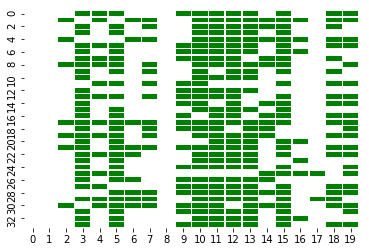

In [22]:
cmap1 = mpl.colors.ListedColormap(['green'])
cmap2 = mpl.colors.ListedColormap(['red'])
sb.heatmap(excess, linewidth=0.5, mask= excess == 0, cmap=cmap1, cbar=False)

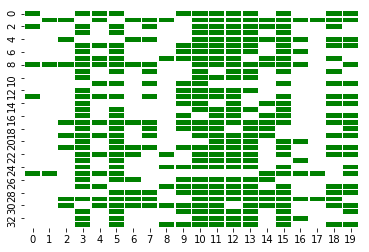

In [26]:
sb.heatmap(excess_presim, linewidth=0.5, mask= excess_presim == 0, cmap=cmap1, cbar=False)

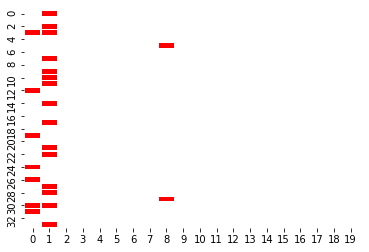

In [23]:
sb.heatmap(shortage, linewidth=0.5, mask= shortage == 0, cmap=cmap2, cbar=False)

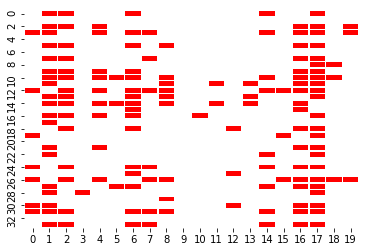

In [24]:
sb.heatmap(shortage_presim, linewidth=0.5, mask= shortage_presim == 0, cmap=cmap2, cbar=False)

In [99]:
## FIRST ATTEMPT AT THE EXCESS/SHORTAGE MATRIX SIMULATION

# Find the facility with the highest demand
priorityfac = np.where(np.sum(shortage, axis=1) == np.amax(np.sum(np.nan_to_num(shortage), axis=1))) # find facility with shortage of drugs
shortage[priorityfac[0]] # list drug-wise demand of facility with the greatest total shortage

# Check which facility's excess best matches above facility's shortage
fullfilment = np.empty(shape = (N,K),dtype = 'object')
for fac in range(N):    # fac represents the facility supplying drugs
    fullfilment[fac] = shortage[priorityfac[0]] - excess[fac]
fullfilment = fullfilment.clip(0) 
bestmatchfac = np.where(np.sum(fullfilment, axis=1) == np.amin(np.sum(fullfilment, axis=1))) 

if np.shape(bestmatchfac)[1] == 1:
    print(priorityfac[0], "receives from", bestmatchfac[0])
    print(fullfilment)
    # this facility provides the best match for the priority facility  

    # Update the shortage and excess of the priorityfac and bestmatchfac based on the above exchange
    excess[bestmatchfac[0]] = excess[bestmatchfac[0]] - (shortage[priorityfac[0]] - fullfilment[bestmatchfac[0]])
    shortage[priorityfac[0]] = fullfilment[bestmatchfac[0]] #shortage[priorityfac[0]] - excess[bestmatchfac[0]]

elif np.shape(bestmatchfac)[1] > 1 and np.shape(bestmatchfac)[1] < N:
    print("Processing facility", priorityfac[0], "which had more than one match in",bestmatchfac[0] )
    
    # From the best matches available, choose the facility with the least supply of drugs
    excess_sum = np.empty(shape = (N,1),dtype = 'object')
    for i,row in enumerate(np.transpose(bestmatchfac)):
        excess_sum[row] = np.sum(excess[row], axis=1)
    np.sum(excess[bestmatchfac[0]])
    bestmatchfac = np.where(excess_sum == np.amin(np.sum(excess_sum, axis=1)))
    
    print(priorityfac[0], "receives from", bestmatchfac[0], "since it has the lowest execess supply among best matches")
    # Update the shortage and excess of the priorityfac and bestmatchfac based on the above exchange
    excess[bestmatchfac[0]] = excess[bestmatchfac[0]] - (shortage[priorityfac[0]] - fullfilment[bestmatchfac[0]])
    shortage[priorityfac[0]] = fullfilment[bestmatchfac[0]] #shortage[priorityfac[0]] - excess[bestmatchfac[0]]
    
else:
    print("Skipping facility", priorityfac[0], "due to too many matches - ", bestmatchfac[0])
    priorityfac = np.where(np.sum(shortage, axis=1) == np.unique(np.sum(shortage, axis=1))[-2]) # find facility with second-highest shortage of drugs
    shortage[priorityfac[0]] # list drug-wise demand of facility with the greatest total shortage

Skipping facility [0] due to too many matches -  [0 1 2 3]


In [102]:
# Matrix of road distance (and a matrix of travel time?)

# Sort facilities by district
#coord = coord_preserve.sort_values('district')

### Try for one district
dist_matrix = np.empty(shape = (len(coord),len(coord)),dtype = 'object')
N = len(coord)
for i in range(N):
    for j in range(N):
        try:
            # Define origin and destination
            latorigin = coord['lat'][i]
            longorigin = coord['long'][i]
            origin = (latorigin,longorigin)

            latdest = coord['lat'][j]
            longdest = coord['long'][j]
            dest = (latdest,longdest)

            # Extract distance and travel time values
            result_dist = gmaps.distance_matrix(origin,dest, mode='driving')['rows'][0]['elements'][0]['distance']['value']
           # result_time = gmaps.distance_matrix(origin,dest, mode='driving')['rows'][0]['elements'][0]['duration']['value']

            # Update distance matrix array
            dist_matrix[i][j] = result_dist
            
        except:
            pass